In [1]:
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
panel

In [5]:
FREQ = 250 # Hz
ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]

def plot_electrode(x):
    plt.plot(np.linspace(-200,600,201), x, alpha=0.5)

def plot_welch(x):
    f, power = signal.welch(x, fs=FREQ, nperseg=len(x), nfft=2048)
    plt.plot(f, power, '-')
    #plt.yscale('log')
    plt.xlim(-2,45)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [V^2/Hz]')

# Un solo Epoch

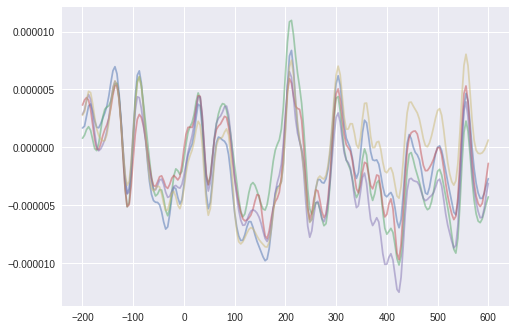

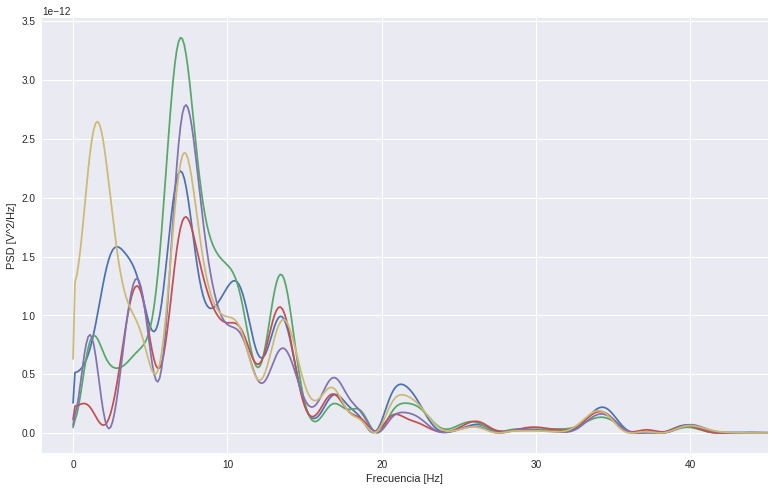

In [87]:
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(panel[0,electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(panel[0,electrode])
plt.show()

# Promedio entre Epochs

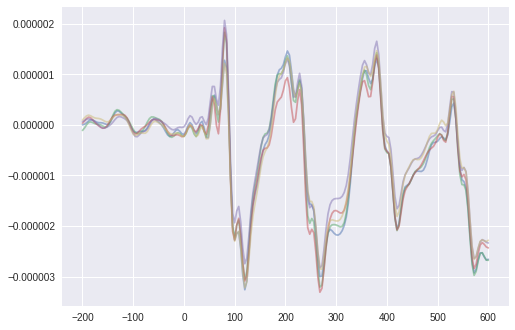

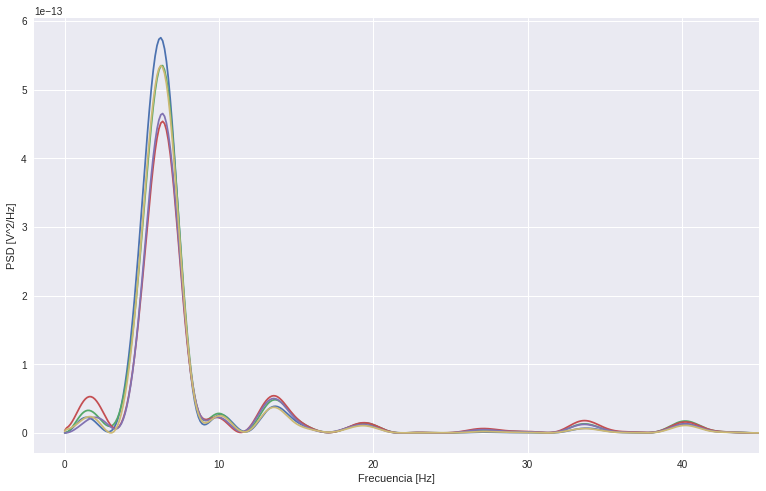

In [89]:
def mean_between_epochs(panel):
    return panel.mean(0)

mean_df = mean_between_epochs(panel).T

for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(mean_df[electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(mean_df[electrode])
plt.show()


In [117]:
def mean_between_electrodes(panel, electrodes):
    return panel[:,electrodes].mean(1)

def fourier_per_epoch(panel, electrodes):
    samples_per_epoch = mean_between_electrodes(panel, electrodes)
    relevant_frecuencies = 38
    res = []
    for _, samples in samples_per_epoch.iteritems():
        frequencies, powers = signal.welch(samples, FREQ, nperseg=len(samples))
        res.append(powers[:relevant_frecuencies])
    return np.asarray(res), frequencies[:relevant_frecuencies]

spectrogram_alpha, frequencies_alpha = fourier_per_epoch(panel, ALPHA_RELEVANT_ELECTRODES)
#spectrogram_all, frequencies_all = fourier_per_epoch(panel, range(256))

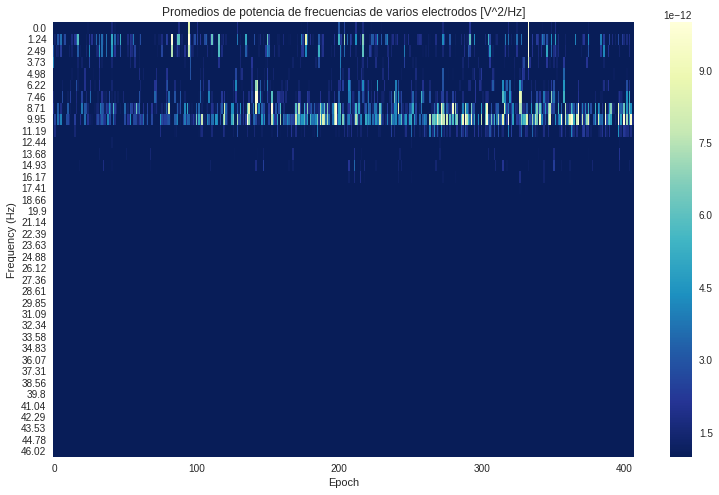

In [118]:
def plot_spectrogram(spectrogram, frequencies):
    spectrogram = spectrogram.T
    plt.figure(figsize=(13, 8))
    ax = sns.heatmap(spectrogram, 
                     xticklabels=100, yticklabels=frequencies.round(2), 
                     #cbar_kws=('PSD [V**2/Hz]'),
                     vmin=0.1e-11, vmax=1e-11, 
                     #center=1.5e-11,
                     cmap='YlGnBu_r'
                     )
    plt.title('Promedios de potencia de frecuencias de varios electrodos [V^2/Hz]')
    plt.xlabel('Epoch')
    plt.ylabel('Frequency (Hz)')
    plt.show()

plot_spectrogram(spectrogram_alpha, frequencies_alpha)

# Categorizamos las frecuencias según su tipo

In [6]:
def mean_power_per_frequency_range(panel):
    mean_samples = panel.mean(0).mean(0)

    def belongs(frequency_range, frequency):
        return frequency_range[0] <= frequency < frequency_range[1]

    frequencies, power = signal.welch(mean_samples, fs=FREQ, nperseg=len(mean_samples), nfft=2048)
    #plt.plot(frequencies, power)
    #plt.show()
    limits = {'delta': (0,4), 'tita': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30, 45)}
    values_by_range = {'delta':[], 'tita':[], 'alpha':[], 'beta':[], 'gamma':[]}

    for f, p in zip(frequencies, power):
        for key, limit in limits.items():
            if belongs(limit, f):
                values_by_range[key].append(p)

    return {key: np.mean(value) for key, value in values_by_range.items()}

In [8]:
import gc
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('data') if f.endswith('.mat')]

powers_per_frequency_range = []
for filename in onlyfiles:
    print(filename)
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    print(mean)
    powers_per_frequency_range.append(mean)
    del mat
    del panel
    gc.collect()

S02.mat
{'delta': 4.4721789923795523e-18, 'gamma': 6.5046616037369745e-20, 'alpha': 1.4993574702413982e-18, 'beta': 6.1728146038718754e-19, 'tita': 2.4688362961442291e-18}
P04.mat
{'delta': 6.4392839982924175e-18, 'gamma': 6.4196029373299024e-21, 'alpha': 1.9337285366324937e-19, 'beta': 2.817521042154207e-20, 'tita': 3.0551946844741552e-18}
P08.mat
{'delta': 2.9948082691808323e-16, 'gamma': 1.5153310346614923e-19, 'alpha': 4.2583232620243461e-18, 'beta': 9.7090706467004435e-19, 'tita': 1.2156540752993797e-16}
P03.mat
{'delta': 8.4558785393704907e-17, 'gamma': 3.1003763704852381e-19, 'alpha': 3.9570200879621949e-18, 'beta': 7.8685646005464051e-19, 'tita': 6.6281056311275017e-18}
S01.mat
{'delta': 1.7582676646843044e-17, 'gamma': 4.2885229921038398e-20, 'alpha': 1.0264831187862492e-18, 'beta': 1.172613383759969e-19, 'tita': 3.8170613035099185e-18}
S09.mat
{'delta': 9.2454729362332454e-15, 'gamma': 1.7766254159193154e-16, 'alpha': 2.3606396864112971e-15, 'beta': 7.8778019069199472e-16, 't

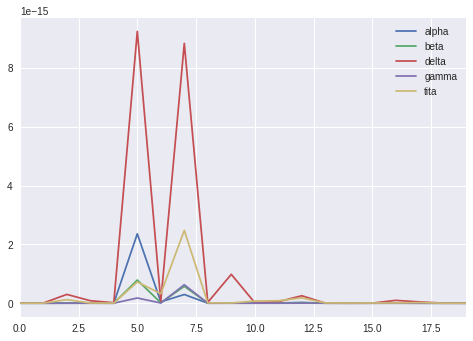

In [14]:
pd.DataFrame(powers_per_frequency_range).plot()
plt.show()